# **Spatial Patterns of insect Diversity in continetal Ecuador**

### **Data processing and cleaning**

Author: Daning Montaño - Ocampo

In this first part of the process, the biodiversity records are cleaned up to Species Level

# **1. Packages and libraries**

In [2]:
library(dplyr)
library(bdc) ## data cleaning
library(lubridate)
library(stringr)
library(doParallel)
library(CoordinateCleaner)
library(purrr)


Attaching package: ‘dplyr’

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



Warning message:
package ‘dplyr’ was built under R version 4.3.3 
Warning message:
package ‘bdc’ was built under R version 4.3.3 



Attaching package: ‘lubridate’

The following objects are masked from ‘package:base’:

    date, intersect, setdiff, union



Warning message:
package ‘lubridate’ was built under R version 4.3.3 


Loading required package: foreach
Loading required package: iterators
Loading required package: parallel


Warning message:
package ‘doParallel’ was built under R version 4.3.3 



Attaching package: ‘purrr’

The following objects are masked from ‘package:foreach’:

    accumulate, when



# **2. Load and homogenize Data**

We used data from:
- Global Biodiversity Information Facility (GBIF)
- PUCE - museum
- iDigBio
- Base nacional de datos de biodiversidad (BNDB)

To homogenize and clean the data from different databases we used "bdc" package. 

Metadata file contains the information of the different columns names of the databaases and assing a unique name in a single database.

In [3]:
metadata <- readr::read_delim("Data/Records/metadata.csv", delim = ";",show_col_types = FALSE)



Load the data using metadata file parameters

In [4]:
database<-
  bdc_standardize_datasets(metadata = metadata,
                           format = "csv",
                           overwrite = T,
                           save_database = T)




Standardizing IDIGBIO file
Standardizing BNDB file
Standardizing GBIF file
Standardizing PUCE file
C:/PROYECTOS/articulos/Spatial_patterns_insects/CODIGOS/Output/Intermediate/00_merged_database.csv was created


Warning messages:
1: One or more parsing issues, call `problems()` on your data frame for details, e.g.:
  dat <- vroom(...)
  problems(dat) 
2: One or more parsing issues, call `problems()` on your data frame for details, e.g.:
  dat <- vroom(...)
  problems(dat) 


Create a new column with the name of the data source

In [5]:

database$database_name =sub("_.*", "", database$database_id)
unique(database$database_name)

[1] "BNDB"    "GBIF"    "IDIGBIO" "PUCE"   

Since the Year variable is not created properly in the PUCE dataset, we use verbatimEventDate to create the values in Year only for the PUCE dataset.

In [6]:
idx <- str_trim(database$database_name) == "PUCE"
database$year[idx] <- as.integer(
  lubridate::year(lubridate::ymd_hms(as.character(database$verbatimEventDate[idx]),
                                     tz = "UTC", quiet = TRUE))
)

Inicial dimension of the dataset

In [7]:
dimension = database %>%
  group_by(database_name)%>%
  count()%>%
  ungroup()%>%
  mutate(prop = (n/sum(n))*100)

dimension

# A tibble: 4 × 3
  database_name      n  prop
  <chr>          <int> <dbl>
1 BNDB           11342  2.80
2 GBIF          306290 75.7 
3 IDIGBIO        70236 17.4 
4 PUCE           16735  4.14

In [8]:
len_0 = sum(dimension$n)
cat("Dataset size:", len_0)

Dataset size: 404603

# **3. Cleaning**

## 3.1. Clean repeated ocurrendIDs

In [9]:
database_1 = database %>%
  distinct(occurrenceID, .keep_all = TRUE)
dimension_1= database_1 %>%
  group_by(database_name)%>%
  count()%>%
  ungroup()%>%
  mutate(prop = (n/sum(n))*100)

dimension_1

# A tibble: 4 × 3
  database_name      n  prop
  <chr>          <int> <dbl>
1 BNDB           11342  2.86
2 GBIF          298838 75.2 
3 IDIGBIO        70231 17.7 
4 PUCE           16735  4.21

In [10]:
len_1= sum(dimension_1$n)
cat("Dataset size:", len_1)

Dataset size: 397146

## 3.2. Select only species level data

We only keeped data from Species level. We filter using all the ways of species could be written.
NA values ara manteined despite the fact that they comes from BNDN data, wich does not have Taxon rank information, for this we delete using NA in taxon Name

In [11]:
unique(database_1$TaxonRank)

 [1] "Genus"       "Species"     "Family"      "Order"       "Subgenus"    "Suborder"    "SPECIES"     "GENUS"       "FAMILY"      "SUBSPECIES"  "ORDER"      
[12] "UNRANKED"    "CLASS"       NA            "Subfamily"   "order"       "family"      "tribe"       "genus"       "species"     "subfamily"   "Subspec"    
[23] "Tribe"       "class"       "Class"       "Subspecies"  "var."        "subspecies"  "superorder"  "superfamily" "subgenus"    "form"       

In [12]:
database_2 = database_1 %>%
  filter(TaxonRank %in% c( "Species","SPECIES" ,  "SUBSPECIES", "Subspecies", "species", "subspecies", "Species group", "Subspec", NA))  %>%
  filter(!is.na(scientificName ))%>%
  filter(class=="Insecta")
dimension_2 = database_2 %>%
  group_by(database_name)%>%
  count()%>%
  ungroup()%>%
  mutate(prop = (n/sum(n))*100)

dimension_2

# A tibble: 4 × 3
  database_name      n   prop
  <chr>          <int>  <dbl>
1 BNDB            1097  0.567
2 GBIF          127853 66.1  
3 IDIGBIO        47854 24.7  
4 PUCE           16735  8.65 

In [13]:

len_2= sum(dimension_2$n)
cat("Dataset size:", len_2)

Dataset size: 193539

## 3.4 Filter date (1970 - 2024)

Exploration of year variable

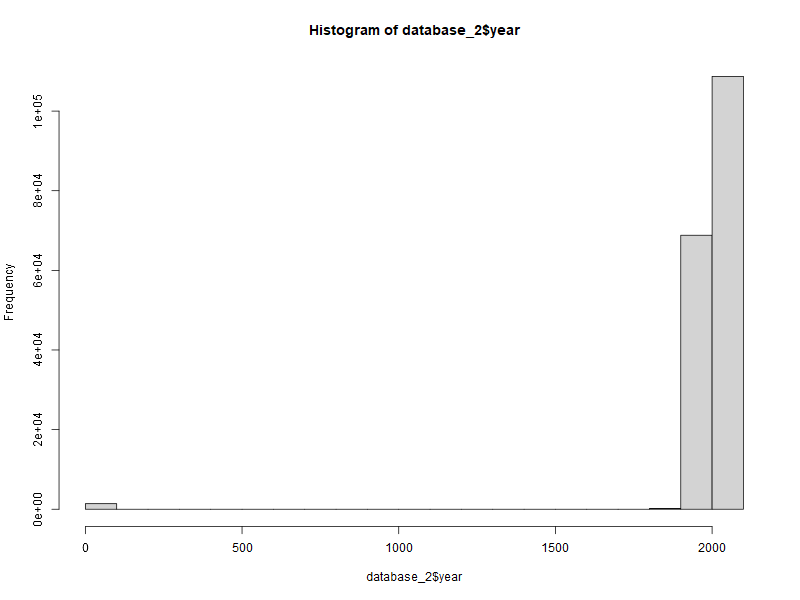

In [14]:
database_2$year = as.numeric(database_2$year)
hist(database_2$year)


Filtering 1970 - 2024

In [15]:
cat( "Min year", min(na.omit(database_2$year)))

Min year 0

In [16]:
cat( "Max year", max(na.omit(database_2$year)))

Max year 2024

In [56]:
database_3 = database_2 %>%
  filter(!is.na(year)) %>%
  filter(year >= 1900) %>%
  filter(year <= 2024) 
dimension_3 = database_3 %>%
  group_by(database_name)%>%
  count()%>%
  ungroup()%>%
  mutate(prop = (n/sum(n))*100)

dimension_3

# A tibble: 4 × 3
  database_name      n   prop
  <chr>          <int>  <dbl>
1 BNDB            1064  0.599
2 GBIF          118277 66.6  
3 IDIGBIO        41502 23.4  
4 PUCE           16701  9.41 

In [57]:

len_3= sum(dimension_3$n)
cat("Dataset size:", len_3)

Dataset size: 177544

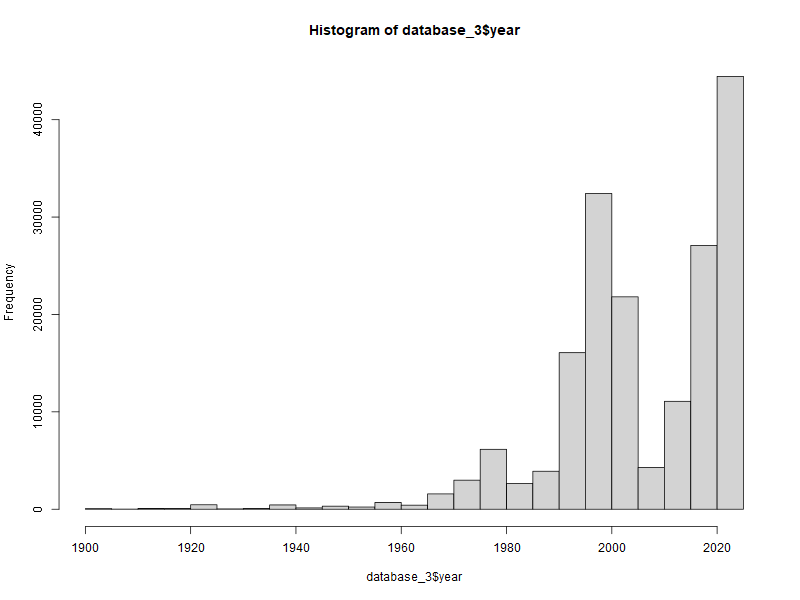

In [58]:
hist(database_3$year)

## 3.3. Delete Empy coordinates

In [59]:
database_4 = database_3 %>% 
  filter(!is.na(decimalLatitude)) %>% 
  filter(!is.na(decimalLongitude)) 
dimension_4 = database_4 %>%
  group_by(database_name)%>%
  count()%>%
  ungroup()%>%
  mutate(prop = (n/sum(n))*100)

dimension_4

# A tibble: 4 × 3
  database_name      n   prop
  <chr>          <int>  <dbl>
1 BNDB            1064  0.599
2 GBIF          118277 66.6  
3 IDIGBIO        41502 23.4  
4 PUCE           16701  9.41 

In [60]:
len_4= sum(dimension_4$n)
cat("Dataset size:", len_4)

Dataset size: 177544

## 3.5. Filter coordinates out of range

The funtions from bdc packages add flags to the data frame to indicate if there is a problem with the data

In [61]:
database_5 = bdc_coordinates_outOfRange(data = database_4, 
lat = "decimalLatitude",
lon = "decimalLongitude") %>%
  filter(.coordinates_outOfRange == TRUE)

dimension_5 = database_5 %>%
  group_by(database_name)%>%
  count()%>%
  ungroup()%>%
  mutate(prop = (n/sum(n))*100)

dimension_5


bdc_coordinates_outOfRange:
Flagged 0 records.
One column was added to the database.



# A tibble: 4 × 3
  database_name      n   prop
  <chr>          <int>  <dbl>
1 BNDB            1064  0.599
2 GBIF          118277 66.6  
3 IDIGBIO        41502 23.4  
4 PUCE           16701  9.41 

In [62]:
len_5= sum(dimension_5$n)
cat("Dataset size:", len_5)

Dataset size: 177544

## 3.6. Filter coordinate Uncertainty

We only keep records with an accuracy of less than 10 km. If the value is NA, it is retained and other types of spatial filters are applied in the following steps.

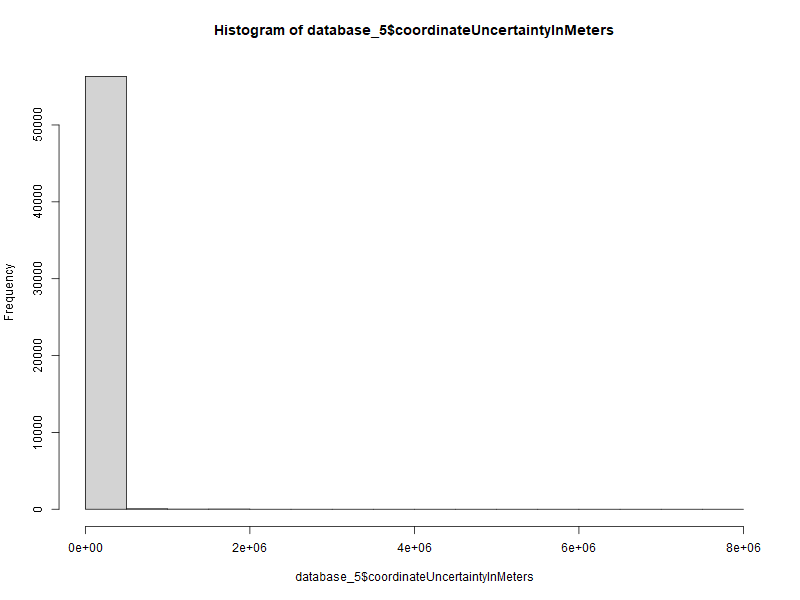

In [63]:
database_5$coordinateUncertaintyInMeters = as.numeric(database_5$coordinateUncertaintyInMeters)
hist(database_5$coordinateUncertaintyInMeters)

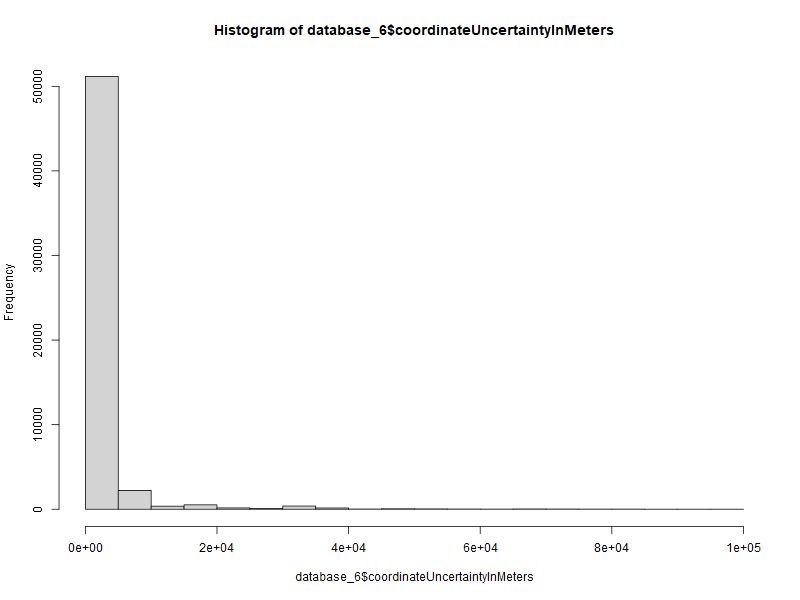

In [64]:
database_6 = database_5%>%
  filter(coordinateUncertaintyInMeters <= 100000| is.na(coordinateUncertaintyInMeters))

hist(database_6$coordinateUncertaintyInMeters)

In [65]:
dimension_6 = database_6 %>%
  group_by(database_name)%>%
  count()%>%
  ungroup()%>%
  mutate(prop = (n/sum(n))*100)

dimension_6

# A tibble: 4 × 3
  database_name      n   prop
  <chr>          <int>  <dbl>
1 BNDB            1064  0.603
2 GBIF          117626 66.7  
3 IDIGBIO        41044 23.3  
4 PUCE           16701  9.47 

In [66]:
len_6= sum(dimension_6$n)
cat("Dataset size:", len_6)

Dataset size: 176435

database_6

## 3.7. Classify only Genus and uncertainties

In [67]:
identify_uncert <- function(name) {
  uncer_terms <- FALSE
  infraesp_names <- FALSE
  generic_only <- FALSE
  
  # Incertidumbre ("cf.", "aff.", "?", "nr.", "indet.", "undet")
  if (grepl("\\b(cf\\.?|aff\\.?|nr\\.?|indet\\.?|undet\\.?|\\?)\\b", name, ignore.case = TRUE)) {
    uncer_terms <- TRUE
  }
  

  
  # Género sin especie ("sp.", "spp.")
 # if (grepl("\\b(sp\\.|spp\\.)\\b", name, ignore.case = TRUE)) {
  #  generic_only <- TRUE
  #}
  
  return(list(
    name = name,
    uncer_terms = uncer_terms

    #generic_only = generic_only
  ))
}


In [68]:
sp_names = unique(database_6$scientificName)
uncertain_results <- map(sp_names , identify_uncert)
uncertain_results_df <- do.call(rbind, lapply(uncertain_results, as.data.frame))
uncertain_results_df

There were 50 or more warnings (use warnings() to see the first 50)


                                                        name uncer_terms
1                                               Ninia atrata       FALSE
2                                              Ninia hudsoni       FALSE
3                              Achoropsyche duodecimpunctata       FALSE
4                                   Anomalocosmoecus illiesi       FALSE
5                                          Cailloma lucidula       FALSE
6                                      Cyrnellus mammillatus       FALSE
7                                 Nectopsyche quatuorguttata       FALSE
8                                      Nectopsyche splendida       FALSE
9                                  Oecetis pseudoinconspicua       FALSE
10                                          Wormaldia planae       FALSE
11                                      Acanthagrion apicale       FALSE
12                                   Acanthagrion floridense       FALSE
13                                    Acanthagrion 

In [69]:
database_7 = database_6 %>%
  left_join(uncertain_results_df, by = c("scientificName" = "name"))%>%
  filter(uncer_terms == FALSE)# %>%
  #filter(generic_only == FALSE)
dimension_7 = database_7 %>%
  group_by(database_name)%>%
  count()%>%
  ungroup()%>%
  mutate(prop = (n/sum(n))*100)

dimension_7

# A tibble: 4 × 3
  database_name      n   prop
  <chr>          <int>  <dbl>
1 BNDB            1064  0.604
2 GBIF          117494 66.7  
3 IDIGBIO        40990 23.3  
4 PUCE           16701  9.48 

In [70]:
len_7= sum(dimension_7$n)
cat("Dataset size:", len_7)

Dataset size: 176249

## 3.8. Cleaning names

In [71]:
sp_names = unique(database_7$scientificName)
sp_names_clean = bdc_clean_names(
  sp_names,
  save_outputs = FALSE
)


>> Family names prepended to scientific names were flagged and removed from 14 records.
>> Terms denoting taxonomic uncertainty were flagged and removed from 146 records.
>> Other issues, capitalizing the first letter of the generic name, replacing empty names by NA, and removing extra spaces, were flagged and corrected or removed from 1 records.
>> Infraspecific terms were flagged and removed from 0 records.



0 → Not interpretable (name could not be parsed).

1 → No problems detected (clean, valid name).

2 → Minor issues (uncertainty terms or small variants, but cleaned successfully).

3 → Moderate issues (complex authorship, ambiguous notation, partially resolved).

4 → Serious problems (multiple inconsistencies, requires manual review).

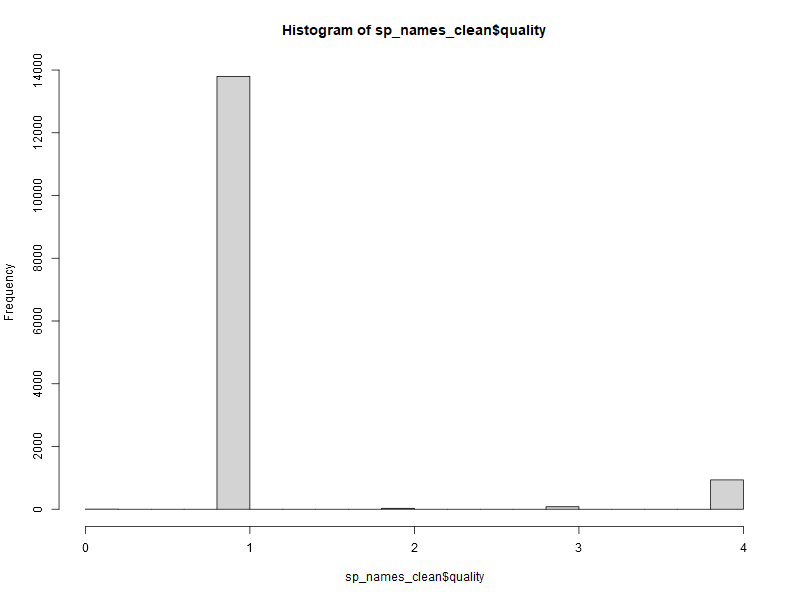

In [72]:
hist(sp_names_clean$quality)

Join clean scientific names with dataframe with all date

In [73]:
database_8 = database_7 %>%
  left_join(sp_names_clean, by = c("scientificName" = "scientificName"))%>%
  filter(quality %in% c(1, 2, 3))

dimension_8 = database_8 %>%
  group_by(database_name)%>%
  count()%>%
  ungroup()%>%
  mutate(prop = (n/sum(n))*100)

dimension_8

# A tibble: 4 × 3
  database_name      n   prop
  <chr>          <int>  <dbl>
1 BNDB            1064  0.639
2 GBIF          108788 65.3  
3 IDIGBIO        40104 24.1  
4 PUCE           16569  9.95 

In [74]:
len_8= sum(dimension_8$n)
cat("Dataset size:", len_8)

Dataset size: 166525

## 3.9. Coordinate precision

1 decimal is aprox 11 km of precision 

In [75]:
database_9 <-
  bdc_coordinates_precision(
    data = database_8,
    lon = "decimalLongitude",
    lat = "decimalLatitude",
    ndec = c(1) # number of decimals to be tested
  )%>%
  filter( .rou == TRUE)
dimension_9 = database_9 %>%
  group_by(database_name)%>%
  count()%>%
  ungroup()%>%
  mutate(prop = (n/sum(n))*100)

print(dimension_9)


bdc_coordinates_precision:
Flagged 1362 records
One column was added to the database.

# A tibble: 4 × 3
  database_name      n   prop
  <chr>          <int>  <dbl>
1 BNDB            1057  0.640
2 GBIF          107902 65.3  
3 IDIGBIO        39866 24.1  
4 PUCE           16338  9.89 


In [76]:
len_9= sum(dimension_9$n)
cat("Dataset size:", len_9)

Dataset size: 165163

## 3.10. Cooordinate cleaner

We filtered the dataset to keep only records that passed the tests for capitals (.cap), centroids (.cen), and outliers (.otl).

- cap → removes records with capitals that are not the main capital of the country.

- cen → removes records near administrative centroids (country or province centroids assigned by default).

- otl → removes geographic outliers that are far from the main distribution of the species.

This ensures that only records with reliable geographic positions remain, reducing the risk of biased results in downstream analyses.

In [77]:
database_9$decimalLatitude = as.numeric(database_9$decimalLatitude)
database_9$decimalLongitude = as.numeric(database_9$decimalLongitude)
database_10 <- CoordinateCleaner::clean_coordinates(
  x       = database_9,
  lon     = "decimalLongitude",
  lat     = "decimalLatitude",
  species = "scientificName",
  tests   = c(
    "capitals",     # cerca de capitales
    "centroids",    # cerca de centroides adm. (país/provincia)
    "institutions", # cerca de instituciones (museos, herbarios, zoos)
    "outliers"    # outliers geográficos por especie
  ),
  capitals_rad      = 100,
  centroids_rad     = 100,
  centroids_detail  = "both",   # país y provincia
  inst_rad          = 100,
  outliers_method   = "quantile",
  outliers_mtp      = 10,
  outliers_td       = 1000,
  outliers_size     = 10,
  zeros_rad         = 0.5
)


Testing coordinate validity
Flagged 0 records.
Testing country capitals
Flagged 13 records.
Testing country centroids
Flagged 13 records.
Testing geographic outliers
Flagged 2837 records.
Testing biodiversity institutions
Flagged 229 records.
Flagged 1278 of 165163 records, EQ = 0.01.


Warning message:
In cc_outl(otl_test, lon = lon, lat = lat, species = species, method = outliers_method,  :
  Species with fewer than 7 unique records will not be tested.


Filter data based in flags asigened 

In [78]:
database_10 = database_10 %>%
  filter(.cap == TRUE) %>%
  filter(.cen == TRUE) %>%
  filter(.otl == TRUE)

dimension_10 = database_10 %>%
  group_by(database_name)%>%
  count()%>%
  ungroup()%>%
  mutate(prop = (n/sum(n))*100)

dimension_10

# A tibble: 4 × 3
  database_name      n   prop
  <chr>          <int>  <dbl>
1 BNDB             391  0.238
2 GBIF          107530 65.5  
3 IDIGBIO        39852 24.3  
4 PUCE           16338  9.96 

In [79]:
len_10= sum(dimension_10$n)
cat("Dataset size:", len_10)

Dataset size: 164111

Delete variables generated in data cleaning process

In [80]:
database_10 = database_10 %>%
  select(c(-.rou,-.val, -.cap, -.cen,-.otl , - .inst ,- .summary))


## 3.11. Validation of taxonomic names

Transform sub species to species level

In [42]:
#sp_names = unique(database_10$names_clean)

#df_sp_level <- tibble(
#  original = sp_names,
#  Species_level = str_extract(sp_names, "^\\S+\\s+\\S+")
#)


#database_10 = database_10 %>%
#  left_join(df_sp_level, by = c("names_clean" = "original")) ## Join data


Using GBIF db

In [81]:

unique_names = unique(database_10$names_clean)
query_names <- bdc_query_names_taxadb(
  sci_name            = unique_names,
  replace_synonyms    = TRUE, # replace synonyms by accepted names?
  suggest_names       = TRUE, # try to found a candidate name for misspelled names?
  suggestion_distance = 0.8, # distance between the searched and suggested names
  db                  = "gbif" , # taxonomic database
  rank_name           = "Insecta", # a taxonomic rank
  rank                = "class", # name of the taxonomic rank
  parallel            = TRUE, # should parallel processing be used?
  ncores              = 8, # number of cores to be used in the parallelization process 
  export_accepted     = FALSE # save names linked to multiple accepted names
)



Querying using gbif database version 22.12

                     
 A total of 0 NA was/were found in sci_name.

 11607 names queried in 11.5 minutes



In [83]:
query_names_gbif = query_names %>%
  select(original_search, distance, notes, taxonID, scientificName, taxonRank,  taxonomicStatus, kingdom,
    phylum, class, order , family,genus, specificEpithet )
notes_sum_gbif = query_names_gbif%>%
  group_by(notes)%>%
  count()%>%
  ungroup()%>%
  mutate(prop = (n/sum(n))*100)

notes_sum_gbif

# A tibble: 12 × 3
   notes                                         n    prop
   <chr>                                     <int>   <dbl>
 1 accepted                                   9983 86.0   
 2 accepted | replaceSynonym                   220  1.90  
 3 accepted | wasMisspelled                    346  2.98  
 4 accepted | wasMisspelled | replaceSynonym    77  0.663 
 5 heterotypic synonym                          10  0.0862
 6 heterotypic synonym | wasMisspelled           9  0.0775
 7 homotypic synonym                           205  1.77  
 8 homotypic synonym | wasMisspelled            14  0.121 
 9 multipleAccepted                             19  0.164 
10 notFound                                    711  6.13  
11 synonym                                       3  0.0258
12 synonym | wasMisspelled                      10  0.0862

Using Catalogue of Life to complement the list of species not accepted by GBIF

In [84]:
not_accepted_gbif = query_names_gbif %>% filter(notes %in% c("heterotypic synonym", "heterotypic synonym | wasMisspelled",
"homotypic synonym", "homotypic synonym | wasMisspelled", "multipleAccepted", "notFound", "synonym", "synonym | wasMisspelled", "NA",
"proparte synonym","synonym", "synonym | wasMisspelled" ))

summary_not_gbif = not_accepted_gbif %>%
  group_by(notes)%>%
  count()%>%
  ungroup()%>%
  mutate(prop = (n/sum(n))*100)

summary_not_gbif

# A tibble: 8 × 3
  notes                                   n   prop
  <chr>                               <int>  <dbl>
1 heterotypic synonym                    10  1.02 
2 heterotypic synonym | wasMisspelled     9  0.917
3 homotypic synonym                     205 20.9  
4 homotypic synonym | wasMisspelled      14  1.43 
5 multipleAccepted                       19  1.94 
6 notFound                              711 72.5  
7 synonym                                 3  0.306
8 synonym | wasMisspelled                10  1.02 

In [85]:

unique_names_col = unique(not_accepted_gbif$original_search)
query_names_col <- bdc_query_names_taxadb(
  sci_name            = unique_names_col,
  replace_synonyms    = TRUE, # replace synonyms by accepted names?
  suggest_names       = TRUE, # try to found a candidate name for misspelled names?
  suggestion_distance = 0.8, # distance between the searched and suggested names
  db                  = "col" , # taxonomic database
  rank_name           = "Insecta", # a taxonomic rank
  rank                = "class", # name of the taxonomic rank
  parallel            = TRUE, # should parallel processing be used?
  ncores              = 8, # number of cores to be used in the parallelization process 
  export_accepted     = FALSE # save names linked to multiple accepted names
)



Querying using col database version 22.12

                     
 A total of 0 NA was/were found in sci_name.

 981 names queried in 9.1 minutes



In [87]:
query_names_col = query_names_col %>%
  select(original_search, distance, notes, taxonID, scientificName, taxonRank,  taxonomicStatus, kingdom,
    phylum, class, order , family,genus, specificEpithet )

notes_sum_col = query_names_col%>%
  group_by(notes)%>%
  count()%>%
  ungroup()%>%
  mutate(prop = (n/sum(n))*100)

notes_sum_col


Using Integrated Taxonomic Information System  to complement the list of species not accepted by COL

In [88]:
not_accepted_col = query_names_col %>% filter(notes %in% c("ambiguous synonym", "ambiguous synonym | wasMisspelled",
"notFound", "accepted | wasMisspelled | replaceSynonym"))

 

In [89]:

unique_names_itis = unique(not_accepted_col$original_search)
query_names_itis <- bdc_query_names_taxadb(
  sci_name            = unique_names_itis,
  replace_synonyms    = TRUE, # replace synonyms by accepted names?
  suggest_names       = TRUE, # try to found a candidate name for misspelled names?
  suggestion_distance = 0.8, # distance between the searched and suggested names
  db                  = "itis" , # taxonomic database
  rank_name           = "Insecta", # a taxonomic rank
  rank                = "class", # name of the taxonomic rank
  parallel            = TRUE, # should parallel processing be used?
  ncores              = 8, # number of cores to be used in the parallelization process 
  export_accepted     = FALSE # save names linked to multiple accepted names
)



Querying using itis database version 22.12

                     
 A total of 0 NA was/were found in sci_name.

 716 names queried in 1.5 minutes



In [90]:
query_names_itis = query_names_itis %>%
  select(original_search, distance, notes, taxonID, scientificName, taxonRank,  taxonomicStatus, kingdom,
    phylum, class, order , family,genus, specificEpithet )

notes_sum_itis = query_names_itis%>%
  group_by(notes)%>%
  count()%>%
  ungroup()%>%
  mutate(prop = (n/sum(n))*100)

notes_sum_itis

# A tibble: 5 × 3
  notes                                         n   prop
  <chr>                                     <int>  <dbl>
1 accepted                                     64  8.94 
2 accepted | wasMisspelled                     10  1.40 
3 accepted | wasMisspelled | replaceSynonym     4  0.559
4 multipleAccepted                              4  0.559
5 notFound                                    634 88.5  

Join all taxa search results

In [91]:
querys_join = rbind(query_names_gbif, query_names_col, query_names_itis) 
querys_join = querys_join%>%distinct(scientificName, .keep_all = TRUE)
summary_taxon_querys = querys_join%>%
  group_by(notes)%>%
  count()%>%
  ungroup()%>%
  mutate(prop = (n/sum(n))*100)

summary_taxon_querys

# A tibble: 7 × 3
  notes                                         n     prop
  <chr>                                     <int>    <dbl>
1 accepted                                  10150 93.9    
2 accepted | replaceSynonym                   242  2.24   
3 accepted | wasMisspelled                    302  2.80   
4 accepted | wasMisspelled | replaceSynonym    97  0.898  
5 notFound                                      1  0.00926
6 synonym                                       3  0.0278 
7 synonym | wasMisspelled                       9  0.0833 

In [92]:
database_10$id_record = seq(1:nrow(database_10))
database_11 = database_10 %>% left_join(querys_join, by = c("names_clean" = "original_search")) %>% distinct(id_record, .keep_all = TRUE)
database_11_sum_notes = database_11%>%
  group_by(notes)%>%
  count()%>%
  ungroup()%>%
  mutate(prop = (n/sum(n))*100)


database_11 = database_11 %>% 
  filter(class.y == "Insecta")%>%
  filter(notes %in% c("accepted", "multipleAccepted" , "accepted | replaceSynonym", 
        "accepted | wasMisspelled", "accepted | wasMisspelled | replaceSynonym","multipleAccepted" ,"provisionally accepted | wasMisspelled"
        ,  "provisionally accepted"  ))%>%
  filter(taxonRank == c("genus", "species"))

dimension_11 = database_11%>%
  group_by(database_name)%>%
  count()%>%
  ungroup()%>%
  mutate(prop = (n/sum(n))*100)

dimension_11

Warning message:
In left_join(., querys_join, by = c(names_clean = "original_search")) :
  Detected an unexpected many-to-many relationship between `x` and `y`.
ℹ Row 3784 of `x` matches multiple rows in `y`.
ℹ Row 1 of `y` matches multiple rows in `x`.
ℹ If a many-to-many relationship is expected, set `relationship = "many-to-many"` to silence this warning.


# A tibble: 4 × 3
  database_name     n   prop
  <chr>         <int>  <dbl>
1 BNDB            195  0.275
2 GBIF          51578 72.7  
3 IDIGBIO       12201 17.2  
4 PUCE           6943  9.79 

In [93]:
len_11= sum(dimension_11$n)
cat("Dataset size:", len_11)

Dataset size: 70917

# 4. Export results

In [104]:
colnames(database_11)

 [1] "database_id"                   "TaxonRank"                     "class.x"                       "family.x"                      "genus.x"                      
 [6] "scientificName.x"              "decimalLatitude"               "decimalLongitude"              "occurrenceID"                  "basisOfRecord"                
[11] "verbatimEventDate"             "country"                       "stateProvince"                 "locality"                      "identifiedBy"                 
[16] "coordinateUncertaintyInMeters" "recordedBy"                    "year"                          "institutionCode"               "database_name"                
[21] ".coordinates_outOfRange"       "uncer_terms"                   ".uncer_terms"                  ".infraesp_names"               "names_clean"                  
[26] "quality"                       "id_record"                     "distance"                      "notes"                         "taxonID"                      
[31] "scie

In [105]:
database_final_export = database_11 %>%select("id_record","database_name" , "database_id","occurrenceID",  "basisOfRecord" ,"verbatimEventDate",
"identifiedBy" , "recordedBy" ,  "year" , "institutionCode" , "taxonRank", "class.y", "order",  "family.y" , "genus.y", "specificEpithet" ,
"scientificName.y" ,  "decimalLatitude"  , "decimalLongitude"    
 )

colnames(database_final_export) = c("id_record","database_name" , "database_id","occurrenceID",  "basisOfRecord" ,"verbatimEventDate",
"identifiedBy" , "recordedBy" ,  "year" , "institutionCode" , "taxonRank", "class", "order",  "family" , "genus", "specificEpithet" ,
"scientificName" ,  "decimalLatitude"  , "decimalLongitude"
 )

write.csv(database_final_export, "Data/Records/insects_records_clean.csv", row.names = FALSE)